In [6]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

class MusicCrawler(object):

    def load_list(self, url):
        req = requests.get(url)
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')

        music_list = soup.find("table")
        trs = music_list.find_all("tr")
        list = []

        for tr in trs[2:]:
            tds = tr.find_all("td")
            regex = re.compile("trackdata+.{10}")
            data = regex.search(str(tr))

            if(data != None):
                track_data = data.group().split('"')[1]

            music_trackid = track_data
            music_title = tds[3].find("span", {"class": "ellipsis"}).get_text().strip()
            music_artist = tds[4].find("a").get_text().strip()
            music_url = "http://music.naver.com/lyric/index.nhn?trackId=" + track_data

            list.append({
                'track_id' : music_trackid,
                'title' : music_title,
                'artist' : music_artist,
                'url' : music_url
            })

        return list


    def load_lyrics(self, url):
        req = requests.get(url)
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')

        try:
            music_title = soup.find("span", {"class" : "ico_play"}).get_text().strip()
            music_lyrics = soup.find("div", {"id" : "lyricText"}).get_text()

            if (music_title != None):
                music_info = []

                music_info.append({
                    'title': music_title,
                    'lyrics' : music_lyrics
                })

                return music_info

        except AttributeError:
            pass
        
        


In [45]:
crawler = MusicCrawler()

music_detail = []

for page in range(1, 3):
    for count in range(1, 2):
        url = "http://music.naver.com/listen/genre/top100.nhn?domain=DOMESTIC&genre=K0"+str(count)+"&page=" + str(page)
        list_ = crawler.load_list(url)
        i = 0

        for item in list_:
            title = list_[i]['title']
            i = i + 1
            music = crawler.load_lyrics(item['url'])
            music_detail.append(music)
            
            
# print(music_detail)
len(music_detail)

100

In [46]:
lyrics = []
for i in range(99):
    if music_detail[i] is not None:
        lyrics.append(music_detail[i][0]['lyrics'])

In [47]:
pd.DataFrame(lyrics).to_csv('한국어_가사.csv')

In [48]:
# rap 모델
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io
import re

Using TensorFlow backend.


In [49]:

text = ''

for index, row in music_detail[0][0].items():
    cleaned = str(row).lower().replace(' ', '\n')
    text = text + " ".join(re.findall(r"['가-힣']+", cleaned))
    
len(text)

340

In [50]:
music_detail[37 : 40] #[0]['lyrics']

[[{'title': '그때가 좋았어',
   'lyrics': '이젠 내가 편하니작은 설렘조차 욕심이겠지항상 곁에 있어서계속 함께 있을 줄 알았나 봐음 반복되는 시간에 지쳐가더 이상 함께 웃을 일도 없어봄처럼 따뜻했던그때가 좋았어너 하나로 충분했던그때가 좋았어헤어지고 나서야깨닫게 됐어참 좋았구나참 예뻤구나 우리지난날에 그때가 참 좋았어그때 그때그때 그때 음이미 너도 다 알잖아돌이킬 수 없이 멀리 왔다는 거억지로 더 노력해도안되는 건 어쩔 수가 없더라음 우리 언제 이렇게 됐을까더는 너를 만날 자신이 없어봄처럼 따뜻했던그때가 좋았어행복해서 눈물 나던그때가 좋았어헤어지고 나서야깨닫게 됐어참 좋았구나참 예뻤구나 우리지난날에 그때가 참 좋았어가진 것도 없고 초라했어도서로만으로 충분했으니까 우린너라서 좋았어행복했어사랑이 전부였던그때가 좋았어그때 알았더라면더 사랑할 걸더 안아줄 걸후회가 돼사랑했던 우리가 참 그리워그때 그때그때 그때 음'}],
 [{'title': '벗',
   'lyrics': '너를 만나고 세상이 모두 변했어의미 없던 하루가 소중해졌으니그냥 길을 걷다가도, 괜히 웃음이 나와 나의 하루는 선물 같아내게 다가왔던 그 순간부터 작은 기적을 안겨준 너에게 말할게 조금 서투른 고백일지라도수많은 사람들 중에 내 곁을 지켜준 사람넌 모든 순간을 꿈꾸게 하니까언제나 너의 곁에서 세상 그 누구보다 소중한 사람이 되고 싶어나의 세상은 너 하나로 가득해서,나의 계절은 항상 따뜻했어더는 무엇도 바라지 않아,지금처럼만 우리, 곁에 있으면 난 충분해내게 다가왔던 그 순간부터 작은 기적을 안겨준 너에게 말할게 조금 서투른 고백일지라도 수많은 사람들 중에 내 곁을 지켜준 사람넌 모든 순간을 꿈꾸게 하니까언제나 너의 곁에서 세상 그 누구보다 소중한 사람이 되고 싶어이토록 눈부시게 아름다운 날약속할게 영원토록 너의 두 손 놓지 않을게고마워 한없이 네게 감사해두 번 다신 없을 나의 너에게 우리가 걷는 이 길이 때론 힘이 들어도 먼 훗날 말하고 싶어 이 길의 끝에 서서 너라서 정말 고마

In [51]:
text = ''

for i in range(99):
    if music_detail[i] != None:
        song = music_detail[i][0]['lyrics']
#         print(song)
        song = re.sub('[\(\)]', ' ', song)
        cleaned = song.lower().replace(' ', '\n')
    #     print(cleaned)
        text = text + " ".join(re.findall(r"[가-힣']+", cleaned))
len(text)

41273

In [52]:
len(music_detail)

100

In [53]:
import re

tokens = re.findall(r"[가-힣'\s]", text)

chars = sorted(list(set(tokens)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 775


In [54]:
chars

[' ',
 "'",
 '가',
 '각',
 '간',
 '갇',
 '갈',
 '감',
 '갑',
 '갔',
 '강',
 '갖',
 '같',
 '개',
 '갠',
 '갤',
 '걔',
 '거',
 '걱',
 '건',
 '걷',
 '걸',
 '겁',
 '것',
 '겉',
 '게',
 '겐',
 '겠',
 '겨',
 '격',
 '견',
 '결',
 '겹',
 '겼',
 '경',
 '곁',
 '계',
 '고',
 '곡',
 '곤',
 '골',
 '곳',
 '공',
 '과',
 '관',
 '괄',
 '광',
 '괜',
 '괴',
 '교',
 '구',
 '국',
 '군',
 '굳',
 '굴',
 '궁',
 '궂',
 '궈',
 '귀',
 '귓',
 '규',
 '그',
 '극',
 '근',
 '글',
 '긁',
 '금',
 '급',
 '긋',
 '기',
 '긴',
 '길',
 '김',
 '깊',
 '까',
 '깜',
 '깝',
 '깥',
 '깨',
 '깰',
 '꺼',
 '껏',
 '껑',
 '께',
 '껴',
 '꼈',
 '꼬',
 '꼭',
 '꼿',
 '꽁',
 '꽃',
 '꽉',
 '꽤',
 '꾸',
 '꾹',
 '꿈',
 '꿎',
 '꿔',
 '뀌',
 '뀐',
 '끄',
 '끈',
 '끊',
 '끌',
 '끔',
 '끗',
 '끝',
 '낀',
 '낄',
 '낌',
 '나',
 '낙',
 '난',
 '날',
 '낡',
 '남',
 '났',
 '낮',
 '낯',
 '내',
 '낸',
 '낼',
 '냈',
 '냐',
 '냥',
 '너',
 '넋',
 '넌',
 '널',
 '넘',
 '넣',
 '네',
 '녀',
 '년',
 '녕',
 '노',
 '녹',
 '놀',
 '놈',
 '농',
 '높',
 '놓',
 '놔',
 '놨',
 '뇌',
 '누',
 '눈',
 '눌',
 '느',
 '는',
 '늘',
 '늙',
 '늦',
 '니',
 '닌',
 '닐',
 '님',
 '다',
 '단',
 '닫',
 '달',
 '닮',
 '담',
 '답',
 '당',
 '닻',
 '닿'

In [55]:
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 13745


In [56]:
chars[0]

' '

In [57]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [58]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

Build model...


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               462848    
_________________________________________________________________
dense_1 (Dense)              (None, 775)               99975     
_________________________________________________________________
activation_1 (Activation)    (None, 775)               0         
Total params: 562,823
Trainable params: 562,823
Non-trainable params: 0
_________________________________________________________________


In [60]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [61]:
def on_epoch_end(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [62]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = decoder_model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

NameError: name 'decoder_model' is not defined

In [97]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

Epoch 1/10
14678/14678 [==============================] - 36s 2ms/step - loss: 4.4923
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " 않아요 단지 이렇게 말해요이렇게 말해요진심이 아니었다고 말해요그게 제일"
 않아요 단지 이렇게 말해요이렇게 말해요진심이 아니었다고 말해요그게 제일 그 있어 이 있어 보 그 없어  다 그 있어그 너 하다 너 보 그 있어 그 사랑하 너 그 사랑이 않 사랑 그 그 그 그 그 사랑 하어 있어  이 없어  다 있어사랑 사랑 그 그 그 사랑을 있어 하 그 사랑 그 사랑 사랑 이 말 그 없어없 그 있어 사랑 사랑 이 그 있어그 그 너 있어 나 그 사랑 하어 나 그 말 그 있어 이 너 사랑 하어  이 사랑 이 그 그 그 그 그 사랑 이 그 너 너 그 그 사랑랑 있어 이 그 사랑 이 있어 이 그 사랑 없어 이 이 사랑 지 그 너 말 그 사랑 내 있어 그 사랑랑 말 그 없어  이 없어 이 있어 그 그 있어 지 그 있어  나 그 말 있어그 사랑 그 그 그 말 너 너 너 그 그 사랑이 이 없어너 사랑 한 말 그 없어 어 없어 하어 그 사랑 사랑을 있어 어 있어 사랑했 없
----- diversity: 0.5
----- Generating with seed: " 않아요 단지 이렇게 말해요이렇게 말해요진심이 아니었다고 말해요그게 제일"
 않아요 단지 이렇게 말해요이렇게 말해요진심이 아니었다고 말해요그게 제일 잊고 아도 너 버어이 혼 러지 흐 하어서 까 아어오 있라 그 말다 너 네  아진 했어 하음 참 사랑라 있어서 그 기해지 마만 오 나 있어어까 랑이 날 있어말 그 주난 말 순 이 모들서 사랑랑 이 사랑했어나게 저 있어사랑랑 거어난 바 말어 있었 어 있 그 그나 까을 사랑여 함오 오여 지 사랑던 마까이 내 그 바개 이 알어 그 번 싶어이 사랑 들 까 없어있어너 아게 이 안 있어그

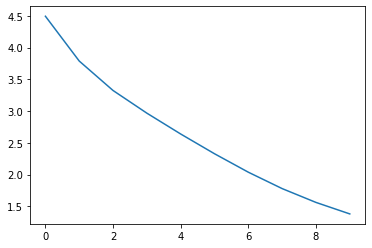

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])

In [35]:
def generate_output():
    generated = ''
    usr_input = input("Write the beginning of your poem, the RAP GENERATOR will complete it. Your input is: ")

    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 0.2)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [99]:
Tx = 40
generate_output()

Write the beginning of your poem, the RAP GENERATOR will complete it. Your input is:  사랑




Here is your poem: 

사랑이 나에게 안해주고 싶어 봐우리 헤어져 가을 내 보내 네 눈물에 더 떠나고 해다른 마음을 타나 봐내 말을 지쳐내 말해줘 아니야 자꾸 가지도 못해서 하나 봐 사랑을 시작하는 너를 다시 게 빛나 아직 너를 사랑해땐 이별 그리워 나를 사랑해저 사람 있었나 봐 니가 그리워 나를 야 이별 너에게 우리 사랑인 사람이 너릴게 가을 내 말에 안 해도 두 날 아직 이별 나를 야 이 술잔을 하고 있는 네 눈치 떠나고 그런 이별이 나버린 마주가 참 그런 내 가을 타나 봐 우리 헤어져 가자이 널 기다리 지무너무 보내 수가 없어그런 사랑을 고백하고 싶다 이별 그런 이별 나를 바보다 가지워 돌아오늘 내가 한 이별오늘 내가 한 이별말 너에게 해줘 사랑해줄 거라면어지고 싶어 이젠 지나 나 혼자 널 기 고 있었그때 우리 헤어져 가을 내 

In [100]:
Tx = 40
generate_output()

Write the beginning of your poem, the RAP GENERATOR will complete it. Your input is:  술잔




Here is your poem: 

술잔을 하지 않아요그대게 밤에 지금만 날 떠나는 내 마음 그리 그날 그런 내 가지막 사랑을 걸까우리 사랑인 사람이 그 사람은 내 마음 좋은 사랑 중 그런 사람이 나서 내가 너와 사랑한 이별말 안하고 싶어 이 순간에도 없어 봐 우리 남은 마음 그리워여기 내가 넌 떠나 너와 나 혼자 널 기다고 그리워 너에게 가라 나 봐나도 헤어지 줘 지워워지고 있어나의 전부야 지나날아 못해서 지금 여 아직 보여 너무 보내 가 자 그리워그때 그 자리에서가운 오늘 밤에서 가슴이다고그렇게 지나 도 아직 보여 너와 그때 때까지나 우리 사랑했잖아우우린 사랑했단 사랑 참 사랑해도사랑 다 말 참 사랑했던그때가 가끔은 내 모습이 될 수가 없어난 미워도 그리워서 이별해줘 한 잔 말 사랑해줄 사람 중 사랑 참 사랑 참 사랑 이 너에게 한 번 너를 

In [103]:
Tx = 40
generate_output()

Write the beginning of your poem, the RAP GENERATOR will complete it. Your input is:  오늘




Here is your poem: 

오늘은 가모두 잊었어 봐요내 맘을 울어요그대 그런 사람들이라는 너를 다 수 있었다 네 사랑을 때사해 이 밤 사랑한 이별말 안하는 이 밤을 나 어나면 지널 나 혼자 널 기다고 그리워 너에게 가라 내 말이 안 해도 안 지금 여기 없어그런 이별해 우리 사랑했던 우리 그때로 가운 내 말에 안 해도 지금 여기 없어그런 이별을 말하는 너를 다시 게 말아서 하지 마 해런 이 밤 지루워 아직 보여 너무 보내 네 워습을 거라고 너를 보려 해도 그래 널 떠나고 그 자리에 나를 보내기가 없어그때 그런 이별해줘 나를 바래래늘이젠가 지나도 그 말해도 안해줘 지금날 아직 보고 싶어그런 이 밤을 소리 없어 너와 내 곁에 지금 더 알아서 마음을 그 자리에서난 떠날고 그런 사랑하는 이별에 널 안하고 싶어 이젠 그리워 나를 보려 해도 그 말은

In [104]:
Tx = 40
generate_output()

Write the beginning of your poem, the RAP GENERATOR will complete it. Your input is:  떠나지마




Here is your poem: 

떠나지마마음이 그대를 그런가 참 그대로 그때로 나를 만나 더 아프게 웃음도 한 날 시간 돌아 돌아 돌아갈 수 없잖아 난 떠 오면 날 바라보다 내 맘에 좋아하는 네 눈치 보다 난 미워하고 있다면 안 보다 싶은 말은 이유 지나 너와 나 혼자 널 기 고 있었내 말아줘 하니 사랑을 말하는 이런 날 떠나고 그 자리에서 난 떠날 그런 사랑을까나봐 우리 사랑을 걸까너를 사랑한다고말하고 싶다 그리워서 내가 가운 내 맘을 울고 있어그런 이별 지나 우리 사랑했잖아사랑했던그때가 좋았어행복하니 사람 다 그런 이별이 너와 나 혼자 널 기 고 있었그때 그런 이별해줘 나일 내 맘에 우리의 마시막 가운 내 맘에 나 혼자 널 기 고 싶다 그때 그런 이별이라고 너 보내 나에게 해 나에게만 다시 사랑을 걸까너를 사랑한다고말 안다 내 말이 안 되는 

## 포인트

- 가수 별로 뽑아 하는 것도 나쁘지 않을 거 가아 -> 왜냐면, 가수마다 말투나, 그런 가사 쓰는 취향이 비슷한 듯. 그래서 가수별로 하는 게 맞을 듯?

- 에폭을 많이 하고?

- lstm말고 딴것도 해볼까? 버트 , 트랜스포머 가능?